In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load the raw Netflix dataset
df = pd.read_csv('../data/raw/netflix_titles.csv')

print("=" * 60)
print("DATA LOADED FOR PREPROCESSING")
print("=" * 60)
print(f"Initial shape: {df.shape}")
print(f"Initial columns: {list(df.columns)}")

# Create a copy for processing
df_clean = df.copy()

DATA LOADED FOR PREPROCESSING
Initial shape: (200, 12)
Initial columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


In [3]:
print("\nMissing values before cleaning:")
print(df_clean.isnull().sum())

# Fill missing values with appropriate defaults
df_clean['director'] = df_clean['director'].fillna('Unknown Director')
df_clean['cast'] = df_clean['cast'].fillna('No Cast Information')
df_clean['country'] = df_clean['country'].fillna('Unknown Country')
df_clean['date_added'] = df_clean['date_added'].fillna('Unknown Date')
df_clean['rating'] = df_clean['rating'].fillna('Not Rated')
df_clean['duration'] = df_clean['duration'].fillna('Unknown Duration')

print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())
print("✓ All missing values handled")



Missing values before cleaning:
show_id          0
type             0
title            0
director        63
cast            20
country         64
date_added       0
release_year     0
rating           0
duration         0
listed_in        0
description      0
dtype: int64

Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64
✓ All missing values handled


In [ ]:
# Feature 1: Content Type (Binary)
df_clean['is_tv_show'] = (df_clean['type'] == 'TV Show').astype(int)
print("✓ Created 'is_tv_show' feature (0=Movie, 1=TV Show)")

# Feature 2: Release Year Normalization
release_years = df_clean['release_year'].fillna(df_clean['release_year'].median())
df_clean['release_year_norm'] = (release_years - release_years.min()) / (release_years.max() - release_years.min())
print("✓ Created 'release_year_norm' feature (normalized to 0-1)")

# Feature 3: Content Age (years since release)
current_year = 2021  # Dataset is from 2021
df_clean['content_age'] = current_year - df_clean['release_year']
df_clean['content_age_norm'] = df_clean['content_age'] / df_clean['content_age'].max()
print("✓ Created 'content_age' and normalized version")

print(f"\nCurrent features shape: {df_clean.shape}")

# Feature Engineering - Rating Encoding
print("\n" + "=" * 60)
print("STEP 3: RATING ENCODING")
print("=" * 60)

# Create rating hierarchy mapping
rating_map = {
    # Kids/Family
    'G': 1, 'TV-Y': 1, 'TV-G': 1,
    # Older Kids
    'PG': 2, 'TV-Y7': 2, 'TV-Y7-FV': 2,
    # Teens
    'PG-13': 3, 'TV-PG': 3,
    # Adults
    'R': 4, 'TV-14': 4,
    # Mature Adults
    'NC-17': 5, 'TV-MA': 5,
    # Not Rated
    'NR': 3, 'UR': 3, 'Not Rated': 3
}

print("Rating hierarchy mapping:")
for rating, level in sorted(rating_map.items(), key=lambda x: x[1]):
    count = (df_clean['rating'] == rating).sum()
    print(f"  {rating:12} → Level {level}  ({count:4} titles)")

# Apply mapping and normalize
df_clean['rating_level'] = df_clean['rating'].map(rating_map).fillna(3)
df_clean['rating_level_norm'] = (df_clean['rating_level'] - 1) / 4  # Normalize to 0-1

print("\n✓ Rating encoded and normalized")
print(f"Rating level distribution:\n{df_clean['rating_level'].value_counts().sort_index()}")


✓ Created 'is_tv_show' feature (0=Movie, 1=TV Show)
✓ Created 'release_year_norm' feature (normalized to 0-1)
✓ Created 'content_age' and normalized version

Current features shape: (200, 16)

STEP 3: RATING ENCODING
Rating hierarchy mapping:
  G            → Level 1  (   1 titles)
  TV-Y         → Level 1  (  10 titles)
  TV-G         → Level 1  (   5 titles)
  PG           → Level 2  (  13 titles)
  TV-Y7        → Level 2  (  14 titles)
  TV-Y7-FV     → Level 2  (   0 titles)
  PG-13        → Level 3  (  28 titles)
  TV-PG        → Level 3  (  22 titles)
  NR           → Level 3  (   0 titles)
  UR           → Level 3  (   0 titles)
  Not Rated    → Level 3  (   0 titles)
  R            → Level 4  (  23 titles)
  TV-14        → Level 4  (  34 titles)
  NC-17        → Level 5  (   0 titles)
  TV-MA        → Level 5  (  50 titles)

✓ Rating encoded and normalized
Rating level distribution:
1    16
2    27
3    50
4    57
5    50
Name: rating_level, dtype: int64


In [5]:
# Extract all genres
all_genres = df_clean['listed_in'].dropna().str.split(',').explode().str.strip()
genre_counts = all_genres.value_counts()

print(f"Total unique genres: {len(genre_counts)}")
print("\nTop 10 genres:")
print(genre_counts.head(10))

# Select top N genres for features
top_n = 10
top_genres = genre_counts.head(top_n).index.tolist()

print(f"\nCreating binary features for top {top_n} genres...")

# Create binary features for each top genre
for genre in top_genres:
    # Create clean column name
    col_name = f"genre_{genre.lower().replace(' ', '_').replace('&', 'and').replace('-', '_')}"
    df_clean[col_name] = df_clean['listed_in'].fillna('').str.contains(genre, case=False).astype(int)
    count = df_clean[col_name].sum()
    print(f"  ✓ {col_name:40} ({count:4} titles)")

print(f"\n✓ Created {top_n} genre features")

# Cell 7: Feature Engineering - Duration Features
print("\n" + "=" * 60)
print("STEP 5: DURATION FEATURE EXTRACTION")
print("=" * 60)

# Extract numeric duration
def extract_duration(duration_str):
    """Extract numeric value from duration string"""
    if pd.isna(duration_str) or duration_str == 'Unknown Duration':
        return np.nan
    numbers = [int(s) for s in str(duration_str).split() if s.isdigit()]
    return numbers[0] if numbers else np.nan

df_clean['duration_numeric'] = df_clean['duration'].apply(extract_duration)

# Separate handling for movies (minutes) and TV shows (seasons)
movies_mask = df_clean['type'] == 'Movie'
tv_mask = df_clean['type'] == 'TV Show'

# For movies: normalize minutes
if movies_mask.any():
    movie_durations = df_clean.loc[movies_mask, 'duration_numeric']
    movie_durations_filled = movie_durations.fillna(movie_durations.median())
    df_clean.loc[movies_mask, 'duration_norm'] = (
        (movie_durations_filled - movie_durations_filled.min()) / 
        (movie_durations_filled.max() - movie_durations_filled.min())
    )
    print(f"✓ Movie duration normalized (range: {movie_durations.min():.0f} - {movie_durations.max():.0f} minutes)")

# For TV shows: normalize seasons
if tv_mask.any():
    tv_durations = df_clean.loc[tv_mask, 'duration_numeric']
    tv_durations_filled = tv_durations.fillna(tv_durations.median())
    df_clean.loc[tv_mask, 'duration_norm'] = (
        (tv_durations_filled - tv_durations_filled.min()) / 
        (tv_durations_filled.max() - tv_durations_filled.min())
    )
    print(f"✓ TV show seasons normalized (range: {tv_durations.min():.0f} - {tv_durations.max():.0f} seasons)")

# Fill any remaining NaN in duration_norm
df_clean['duration_norm'] = df_clean['duration_norm'].fillna(0.5)

Total unique genres: 38

Top 10 genres:
Dramas                    45
International Movies      42
Comedies                  41
Action & Adventure        40
International TV Shows    31
Kids' TV                  22
TV Comedies               20
Thrillers                 17
TV Dramas                 16
Romantic Movies           15
Name: listed_in, dtype: int64

Creating binary features for top 10 genres...
  ✓ genre_dramas                             (  61 titles)
  ✓ genre_international_movies               (  42 titles)
  ✓ genre_comedies                           (  61 titles)
  ✓ genre_action_and_adventure               (  46 titles)
  ✓ genre_international_tv_shows             (  31 titles)
  ✓ genre_kids'_tv                           (  22 titles)
  ✓ genre_tv_comedies                        (  20 titles)
  ✓ genre_thrillers                          (  18 titles)
  ✓ genre_tv_dramas                          (  16 titles)
  ✓ genre_romantic_movies                    (  15 titles)

✓ 

In [6]:
# Extract all countries
all_countries = df_clean['country'].dropna().str.split(',').explode().str.strip()
country_counts = all_countries.value_counts()

# Top producing countries
top_countries = country_counts.head(5).index.tolist()

print("Creating binary features for top 5 countries...")
for country in top_countries:
    col_name = f"country_{country.lower().replace(' ', '_')}"
    df_clean[col_name] = df_clean['country'].fillna('').str.contains(country, case=False).astype(int)
    count = df_clean[col_name].sum()
    print(f"  ✓ {col_name:30} ({count:4} titles)")

print("✓ Created country features")

# Cell 9: Prepare Clustering Features
print("\n" + "=" * 60)
print("STEP 7: PREPARING FINAL FEATURE SET")
print("=" * 60)

# Collect all feature columns
feature_columns = [
    'is_tv_show',
    'release_year_norm',
    'rating_level_norm',
    'duration_norm'
]

# Add genre features
genre_features = [col for col in df_clean.columns if col.startswith('genre_')]
feature_columns.extend(genre_features)


print(f"\nSelected {len(feature_columns)} features for clustering:")
for i, feature in enumerate(feature_columns, 1):
    print(f"  {i:2}. {feature}")

# Create feature matrix
features_df = df_clean[feature_columns].copy()

# Handle any remaining NaN values
features_df = features_df.fillna(0)

print(f"\n✓ Feature matrix shape: {features_df.shape}")
print(f"✓ No missing values: {features_df.isnull().sum().sum() == 0}")

Creating binary features for top 5 countries...
  ✓ country_united_states          (  77 titles)
  ✓ country_unknown_country        (  64 titles)
  ✓ country_india                  (  16 titles)
  ✓ country_united_kingdom         (  16 titles)
  ✓ country_japan                  (  16 titles)
✓ Created country features

STEP 7: PREPARING FINAL FEATURE SET

Selected 14 features for clustering:
   1. is_tv_show
   2. release_year_norm
   3. rating_level_norm
   4. duration_norm
   5. genre_dramas
   6. genre_international_movies
   7. genre_comedies
   8. genre_action_and_adventure
   9. genre_international_tv_shows
  10. genre_kids'_tv
  11. genre_tv_comedies
  12. genre_thrillers
  13. genre_tv_dramas
  14. genre_romantic_movies

✓ Feature matrix shape: (200, 14)
✓ No missing values: True


Feature value ranges:
     is_tv_show  release_year_norm  rating_level_norm  duration_norm  \
min         0.0                0.0                0.0            0.0   
max         1.0                1.0                1.0            1.0   

     genre_dramas  genre_international_movies  genre_comedies  \
min           0.0                         0.0             0.0   
max           1.0                         1.0             1.0   

     genre_action_and_adventure  genre_international_tv_shows  genre_kids'_tv  \
min                         0.0                           0.0             0.0   
max                         1.0                           1.0             1.0   

     genre_tv_comedies  genre_thrillers  genre_tv_dramas  \
min                0.0              0.0              0.0   
max                1.0              1.0              1.0   

     genre_romantic_movies  
min                    0.0  
max                    1.0  


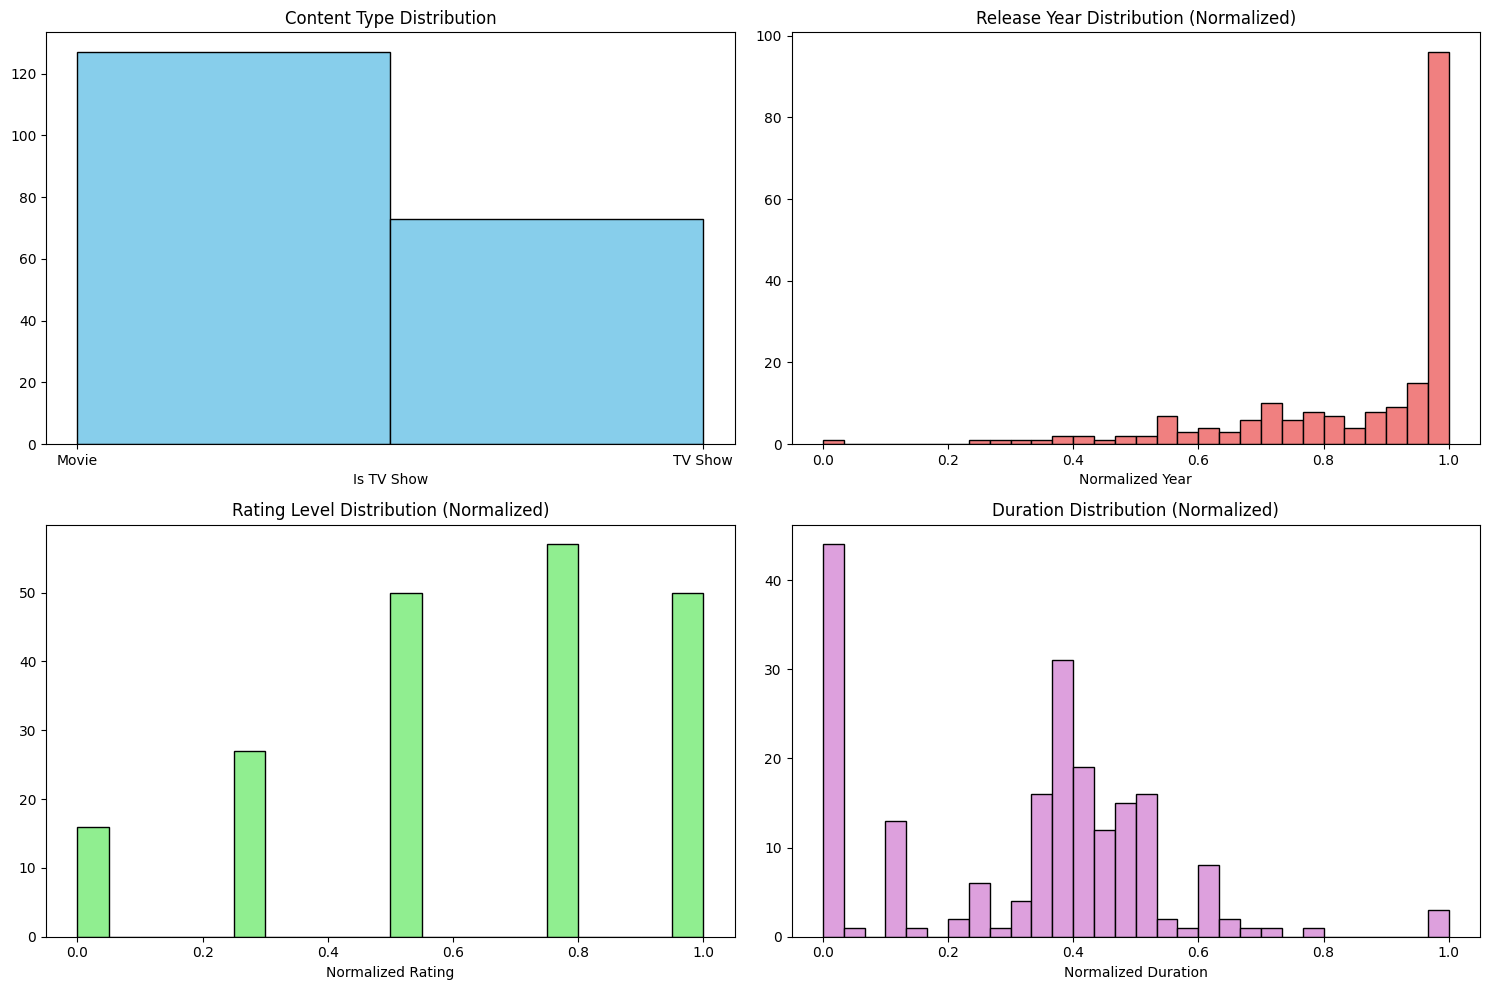

In [7]:
print("Feature value ranges:")
print(features_df.describe().loc[['min', 'max']])

# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Basic features
axes[0, 0].hist(features_df['is_tv_show'], bins=2, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Content Type Distribution')
axes[0, 0].set_xlabel('Is TV Show')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Movie', 'TV Show'])

axes[0, 1].hist(features_df['release_year_norm'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Release Year Distribution (Normalized)')
axes[0, 1].set_xlabel('Normalized Year')

axes[1, 0].hist(features_df['rating_level_norm'], bins=20, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Rating Level Distribution (Normalized)')
axes[1, 0].set_xlabel('Normalized Rating')

axes[1, 1].hist(features_df['duration_norm'], bins=30, color='plum', edgecolor='black')
axes[1, 1].set_title('Duration Distribution (Normalized)')
axes[1, 1].set_xlabel('Normalized Duration')

plt.tight_layout()
plt.show()


Genre feature correlation:


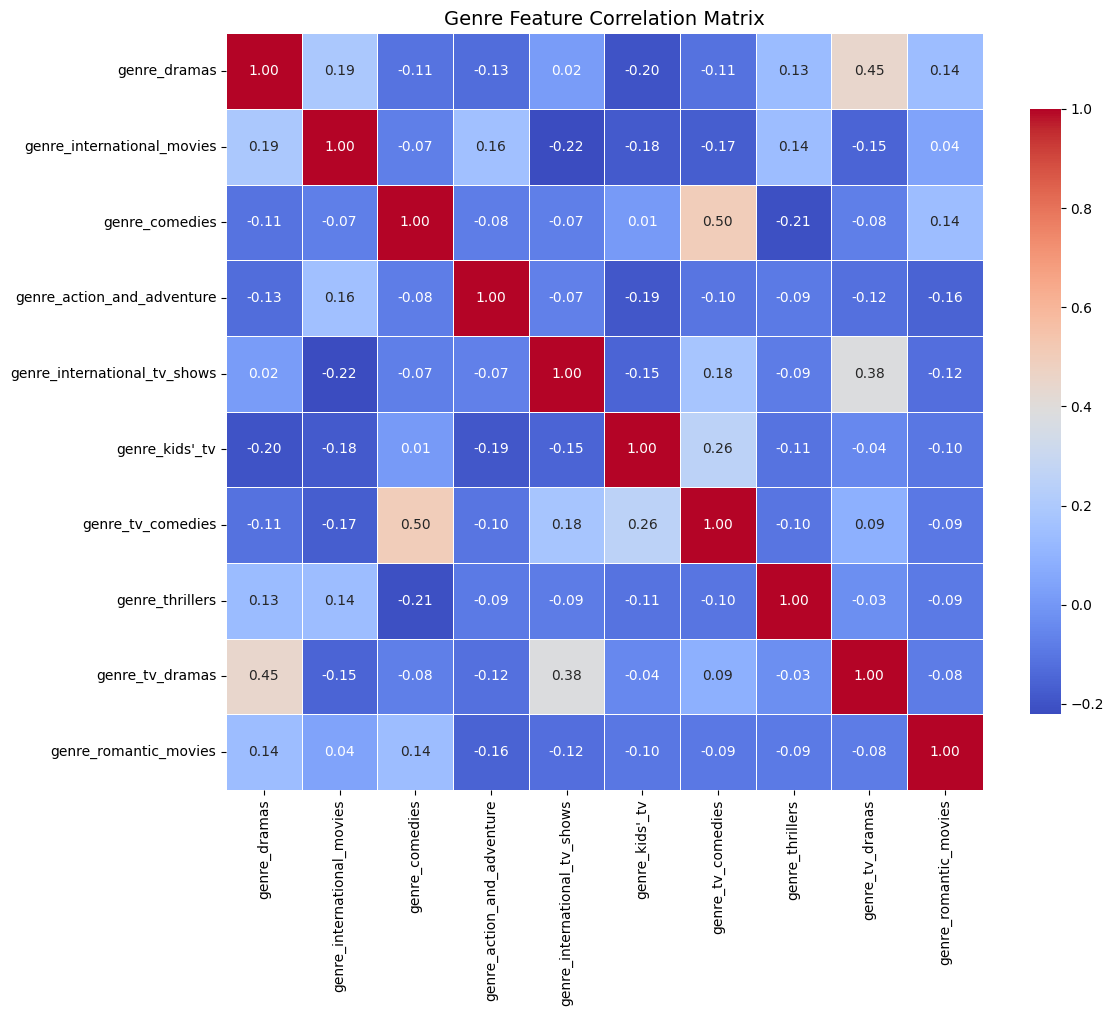

✓ Genre correlations visualized


In [8]:
print("\nGenre feature correlation:")

# Select genre features for heatmap
genre_cols = [col for col in features_df.columns if col.startswith('genre_')]
if len(genre_cols) > 0:
    genre_data = features_df[genre_cols]
    
    # Calculate correlation
    genre_corr = genre_data.corr()
    
    # Visualize
    plt.figure(figsize=(12, 10))
    sns.heatmap(genre_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Genre Feature Correlation Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("✓ Genre correlations visualized")

In [9]:
# Save cleaned full dataset
output_path_full = '../data/processed/netflix_processed.csv'
df_clean.to_csv(output_path_full, index=False)
print(f"✓ Saved full processed dataset: {output_path_full}")
print(f"  Shape: {df_clean.shape}")

# Save feature matrix for clustering
output_path_features = '../data/processed/clustering_features.csv'
features_df.to_csv(output_path_features, index=False)
print(f"✓ Saved clustering features: {output_path_features}")
print(f"  Shape: {features_df.shape}")

# Save feature names for later reference
feature_info = pd.DataFrame({
    'feature_name': feature_columns,
    'feature_type': ['basic' if col in ['is_tv_show', 'release_year_norm', 'rating_level_norm', 'duration_norm'] 
                     else 'genre' for col in feature_columns]
})
output_path_info = '../data/processed/feature_info.csv'
feature_info.to_csv(output_path_info, index=False)
print(f"✓ Saved feature information: {output_path_info}")

✓ Saved full processed dataset: ../data/processed/netflix_processed.csv
  Shape: (200, 35)
✓ Saved clustering features: ../data/processed/clustering_features.csv
  Shape: (200, 14)
✓ Saved feature information: ../data/processed/feature_info.csv
